# 蓄水池抽样浅说
![jar_of_marbles](http://www.jlao.net/wp-content/uploads/2015/10/jar_of_marbles.jpg) 我们有时候会有进行数据抽样的需要，比如要从文件中随机取出若干行，或从数据集中随机取出若干数据进行分析。通常情况下这并不是什么难事，比如 Python 中直接提供了 `random.sample()` 来做这件事，Numpy 中更提供了功能更为强大的 `numpy.random.choice()`。然而这些东西都有一个问题，就是你必须把整个数据集读到内存里。如果数据集超出了内存的限制，或者要对一个持续的输入流做抽样，即**从包含 $n$ 个项目的集合中（等概率）选取 $k$ 个样本，其中 $n$ 为很大或未知**，又该怎么做呢？ 

## 蓄水池

这里介绍的方法都有一个共同的特点，就是建立一个“蓄水池” (reservoir)，池的大小就是要选出的样本大小，如果元素没有充满池子，那自然每个元素都被选进来了。如果池子满了以后还有新的元素来了，就以一定概率从池中换一个元素出去。

举个具体的例子来说吧，输入的是自然数流 1, 2, 3, 4, 5, ... 样本数 $k = 3$，也就是说要保证等概率地从流中选出 3 个元素。前三个数自然先把位子都站好了，这时候 $P = 1$。

输入第四个数 4 的时候，我们先要保证它进入池中的概率是 $\frac{3}{4}$。然后换掉谁呢？1 ~ 3 这三个数被换掉的概率都应该是 $\frac{1}{4}$，于是 1 ~ 4 这四个数留在池中的概率都是 $\frac{3}{4}$。

具体怎么做呢？一种做法是对第 $n$ 项，生成一个 $1 \sim n$ 的随机数 $j$。如果 $j \leq k$，则用第 $n$ 项替换第 $j$ 项。

这个方法对不对呢？利用数学归纳法，假设 $n = N$ 时，第 $i$ 项被抽到的概率

$$P_i(N) = \frac{k}{N}$$

则 $n = N+1$ 时，第 $N+1$ 项被选中的概率

$$P_{N+1}(N+1) = \frac{k}{N+1}$$

而第 $1 \sim N$ 项则要再去掉它在前 $k$ 个元素中被新加进来的项替换掉的情况

$$ \begin{align} P_i(N+1) & = \frac{k}{N} \cdot \left(1 - P_{N+1} \cdot \frac{1}{k}\right)\\ &= \frac{k}{N} \cdot \left(1 - \frac{1}{N+1}\right) \\ &= \frac{k}{N+1} \end{align} $$

我们已经知道，对于 $n = k$ 时，第 $i$ 项被抽到的概率都是 $P_i(k) = 1 = \frac{k}{n}$。于是得证。

这就是所谓的“Algorithm R”。这个东西实现起来也很简单：

In [12]:
import random

def reservoirSample(stream, sample_size):
    result = []
    for index, line in enumerate(stream):
        if index < sample_size:
            result.append(line)
        else:
            r = int(random.random() * (index + 1))
            if r < sample_size:
                result[r] = line
    return result

if __name__ == '__main__':
    print(reservoirSample(range(100), 10))

[35, 96, 91, 60, 17, 87, 6, 7, 50, 27]


## 换个思路

上面这个方法是不是很巧妙？太巧妙了。不过我们还可以有另外一个更简单的思路。比如说，对进来的每一项，都给它指派一个 $[0,1]$ 均匀分布的随机数。然后把所有数字按照升序或者降序排列。最后选出最前面（或者最后面）的 $k$ 项就可以了。 这个东西看起来非常直观啊。不过证明起来……有点搞。不想看的同学请直接跳过：

> 假设一共有 $n$ 项，我们已经定好了要选出的最大的 $k$ 项，那么对于第 $k+1$ 大的那一项，有 $n-k$ 个均匀分布的变量 $u_i$ 都比它小，所以它的分布函数是 $$F(x) = \prod_{i=1}^{n-k}\mathbb{P}(u_i \leq x) = x^{n-k}$$ 而剩下的 $k$ 个变量都比 $x$ 大的概率则是 $(1-x)^k$。于是，要选出一组特定的 $k$ 个元素的样本 $s$ 的概率是 @_@ $$P = \int_0^1 (1-x)^k \mathrm{d} F(x) = (n-k)\int_0^1(1-x)^k x^{n-k-1} \mathrm{d} x$$ 注意到右边是个欧拉积分…… Beta 函数在整数参量的时候有 $$\mathrm{B}(x,y) = \int_0 ^1 t^x(1-t)^y \mathrm{d} t = \frac{x!\,y!}{(x+y+1)!}$$ 套进去就得到了 $$P = (n-k)\,\mathrm{B}(k, n-k-1) = \frac{k!\, (n-k)!}{n!}=\binom{n}{k} ^{-1}$$ 正好是从 $n$ 个样本中选 $k$ 个元素时选到特定一组的概率。证毕。

实现起来倒是很方便，只需要维护一个大小为 $k$ 的堆就可以了：

In [3]:
import random
import heapq

def reservoirSample(stream, sample_size):
    result = []
    for index, line in enumerate(stream):
        key = random.random()
        if index < sample_size:
            heapq.heappush(result, (key, line))
        elif key > heapq.nsmallest(1, result)[0][0]:
            heapq.heappushpop(result, (key, line))
    return list(zip(*result))[1]

if __name__ == '__main__':
    print(reservoirSample(range(100), 10))

(47, 50, 11, 58, 40, 53, 79, 52, 76, 78)


这个方法也很好，只不过是每次操作要维护这个堆需要 $O(\log k)$ 的时间，稍微慢了那么一点点。但是这个思路还有其他的优势，我们后面再谈。 好了，今天先说到这吧。但是问题还没有完。这两种方法需要产生多少随机数呢？$n -k$ 个。而且每一个元素都要放进来比较。有没有快一点的方法呢？


## 跳跳跳！—— Algorithm X

前面介绍的方法都很好，但是要计算 $n-k$ 个随机数实在是有点浪费时间…… 有兴趣的同学可以把那个调用函数换成比如 `reservoirSample(range(10**8), 10**5)`，就知道这东西还是要算上一会儿的了。

再来看看这个过程吧——把前 $k$ 个元素放进去之后，随机决定接下来的元素要不要放进去，但是每次决定时都需要产生一个随机数。要是我们能够确定应该**跳过**多少个元素，不就可以省掉很多生成随机数的工夫了吗？每一步过程就变成了

*   确定该跳过多少个元素 $S(k, n)$
*   跳过 $S(k, n)$ 个元素
*   从前 $k$ 个元素中随机产生一个要替换的元素，用下一个元素替换

那该跳过的元素数 $S(k,n)$ 要怎么定下来呢？这显然也是一个随机数。我们要计算它的累积分布函数 $\mathbb{P}(S(k,n) \leq s)$，即在第 $n$ 个元素出现时，跳过 $s$ 或 $s$ 以内个元素的概率。这似乎有点不那么直观，但是我们可以反过来计算 $1 - \mathbb{P}(S(k,n) > s)$，要跳过超过 $s$ 个元素，不就是从第 $n + 1$ 个到第 $n+s+1$ 个都不被选中嘛！我们知道第 $n$ 个元素被选中的概率是 $k / n$，所以

$$\begin{align} F_S(s) & =\mathbb{P}(S(k,n) \leq s) \\ &= 1 - \mathbb{P}(S(k,n) > s) \\ &= 1 - \left(1 - \frac{k}{n+1}\right)\left(1 - \frac{k}{n+2}\right)\cdots\left(1 - \frac{k}{n+s+1}\right) \\ &= 1 - \frac{(n+1-k)(n+2-k)\cdots(n+s-k+1)}{(n+1)(n+2)\cdots(n+s+1)} \end{align} $$

好啦，概率分布知道了，怎么生成这个概率分布呢？这里又要用到一个生成任意概率分布的技巧，就是所谓的**反变换法**。令 $U$ 是均匀分布在 $[0,1]$ 上的随机变量，如果 $X = F^{-1}(U)$，则

$$F_X(a) = \mathbb{P}(X \leq a) = \mathbb{P}(F^{-1}(U) \leq a) = \mathbb{P}(U \leq F(a)) = F(a)$$

那么在这里，我们只需要生成一个 $[0,1]$ 的随机数 $u$，然后找出让 $F_S(s) \leq u$ 的最小 $s$ 值就好了。这就是所谓的 Algorithm X：

In [ ]:
import random
import sys
import time

def getS(n, k):
    u = random.random()
    S = 0
    n += 1
    quot = (n - k) / n
    while (quot > u):
        S += 1
        n += 1
        quot *= (n - k) / n
    return S

def reservoirSampleX(stream, sample_size):
    result = []
    s = 0
    for index, line in enumerate(stream):
        if index < sample_size:
            result.append(line)
        else:
            if not s:
                result[int(random.random() * sample_size)] = line
                s = getS(index + 1, sample_size)
            else:
                s -= 1
    return result

在 pypy 下测试，从 $10^8$ 个元素生成 $10^5$ 个元素的样本只需要 1.6 秒，而 Algorithm R 则需要 5 秒。但是，原先的 R 算法对样本大小并不怎么敏感，因为总归要算那么多次，而这个 X 算法所花的时间则会随着样本数增加而有所增加。 上面这个算法来自 Vitter 的一篇著名论文[1]，这篇文章针对 $n$ 比较大的时候进一步改进了计算 $s$ 的过程，利用两个函数对 $F(s)$ 进行夹逼从而避免了对 $s$ 的搜索，由此得到了性能进一步提高的 Z 算法。PostgreSQL 就实现了这个 Z 算法来进行数据抽样，有兴趣的同学可以看看[源代码](http://doxygen.postgresql.org/sampling_8c.html#afd4446f95830d0389ef5f2dbdfa5652b)。 前面说的是性能，那如果我们需要不均匀的抽样，有没有办法呢？

## 加个权吧

前面说的是均匀抽样，要是想加个权怎么办呢？先说加权有什么用呢？比如我们已经统计好了搜索的关键字和词频，那么有了加权就可以直接用这个数据来抽样而无需把关键字重复好多遍了。

我们先来看看这个抽样应该是怎么样的。假设这总共 $n$ 项都摆在你面前了，设第 $i$ 项的权值为 $w_i$，那么我们抽到这一项概率应该是

$$P_i = \frac{w_i}{w_1 + w_2 + \cdots + w_n}$$

我们现在来看看，如果把这 $n$ 项按照第 $n$ 项、第 $n-1$ 项、…… 第 $2$ 项、第 $1$ 项的顺序抽出来，这个概率是多少。因为这 $n$ 项的顺序是可以随便摆的，所以它求出来是有一定普遍意义的。

第一次抽出第 $n$ 项的概率是

$$P_n(1) = \frac{w_n}{w_1 + w_2 + \cdots + w_n}$$

第 $n$ 项已经被抽走了，那第二次抽到第 $n-1$ 项的概率是

$$P_{n-1}(2) = \frac{w_{n-1}}{w_1 + w_2 + \cdots + w_{n-1}}$$

以此类推，**按照这个顺序**抽出所有元素的概率就是

$$P(S) = \prod_{i=1}^n \frac{w_i}{w_1+w_2+\cdots w_i} $$

这有什么用呢？别着急，先记下这个结果，我们下面来说说算法怎么做。

其实这个算法简单得不能再简单了——还记得[第 1 讲](http://www.jlao.net/technology/10256/)里面说的那个给每个数标上一个随机数的方法吗？这次只需要给生成的随机数 $U_i$ 上面加一个方次变成 $U_i^{1/w_i}$ 就好了。记得 $U_i$ 是在 $[0,1]$ 之间的，所以 $w_i$ 越大，这个随机数就放得越大，也就越容易挤进堆里面了。程序如下：

In [5]:
def reservoirSampleAES(stream, sample_size):
    result = []
    for index, line in enumerate(stream):
        w = (index + 1)** (1/2)
        key = random.random() ** (1/w)
        if index < sample_size:
            heapq.heappush(result, (key, line))
        elif key > heapq.nsmallest(1, result)[0][0]:
            heapq.heappushpop(result, (key, line))
    return list(zip(*result))[1]

这里我们取的权值是序号的开方，效果如何呢？我做了这样一个仿真：

c:\python35\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


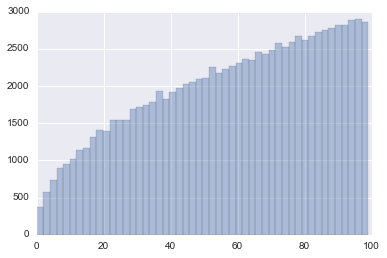

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
a = []
for i in range(10000):
    a.extend(reservoirSampleAES(range(100), 10))
sns.distplot(a, kde=False)

还挺像那么回事的哈。再回过头来看看这个算法是什么道理。我们现在要证明的就是，既然 $U_i$ 都是 $[0,1]$ 上均匀分布的随机数，$w_i$ 是权值，那么以特定顺序排列 $X_i = U_i ^{1/w_i}$ 的概率和前面说的加权抽取一样：

$$\mathbb{P}[X_1 \leq X_2 \leq \cdots \leq X_n \leq 1] = \prod_{i=1}^n \frac{w_i}{w_1+w_2+\cdots w_i}$$

这个还得来数学归纳法…… 首先，对于 $t \in [0,1]$，$w_i > 0$，分布函数

$$F_{X_i}(t) = \mathbb{P}[X_i \leq t] = \mathbb{P}\big[ U_i^{1/w_i}\leq t\big] = \mathbb{P}\big[U_i \leq t^{w_i}\big] = t^{w_i}$$ 那么概率密度函数

$$f_{X_i}(t) = F_{X_i}'(t) = w_i\cdot t^{w_i -1}$$ $n=1$ 时，$\mathbb{P}[U_1 \leq \alpha^{w_1}] = \alpha^{w_1}$ $n=2$ 时，

$$\begin{align} \mathbb{P}[U_1 \leq U_2 \leq \alpha^{w_1}] &= \int_0^\alpha F_{X_1}(t)\,f_{X_2}(t) \mathrm{d}t\\ &=\int_0^\alpha t^{w_1}\cdot w_2 t^{w_2-1}\mathrm{d}t = \frac{w_2}{w_1 + w_2}\cdot \alpha^{w_1+w_2} \end{align}$$ 那么如果 $n=k$ 时，$$\mathbb{P}[X_1 \leq X_2 \leq \cdots \leq X_k \leq \alpha] = \alpha^{\sum_{i=1}^k w_i}\prod_{i=1}^k \frac{w_i}{w_1+w_2+\cdots w_i}$$

则 $n=k+1$ 时，

$$\begin{align} &\phantom{==} \mathbb{P}[X_1 \leq X_2 \leq \cdots \leq X_{k+1} \leq \alpha] \\ &= \int_0^\alpha \mathbb{P}[X_1 \leq X_2 \leq \cdots \leq X_k \leq t]\cdot f_{X_{k+1}}(t) \mathrm{d}t\\ &=\int_0^\alpha \left(\prod_{i=1}^k \frac{w_i}{w_1+w_2+\cdots w_i}\right) t^{\sum_{i=1}^k w_i}\cdot w_{k+1} t^{w_{k+1}-1}\mathrm{d}t \\ &= \left(\prod_{i=1}^k \frac{w_i}{w_1+w_2+\cdots w_i}\right)w_{k+1} \int_0^\alpha t^{\sum_{i=1}^{k+1} w_i-1}\mathrm{d}t \\ &=\alpha^{\sum_{i=1}^{k+1} w_i}\prod_{i=1}^{k+1} \frac{w_i}{w_1+w_2+\cdots w_i} \end{align}$$

$\alpha = 1$ 的时候前面那一项就没有了，所以对于任意元素排列，用 $U_i^{1/w_i}$ 方法得到它的概率和直接加权抽取得到的概率是一样的。这样就证明了这个方法是可行的。 虽然证明看起来啰嗦了点，但是不得不说这个结果简单优雅，真的太精到了。以前虽然也有一些加权抽样的算法，但是都不能像这个实现未知总数时的线上抽样。直到 2005 年这个算法才被提出来。 Cloudera 的机器学习项目 Oryx 里面就应用了这个加权抽样算法，代码可以看[这里](https://github.com/cloudera/oryx/blob/master/kmeans-common/src/main/java/com/cloudera/oryx/kmeans/common/Weighted.java)。当然它写的是对随机数取对数再除以权值，这个算起来当然是比直接开 $w_i$ 次方要快一点啦。

## 参考资料
1.  Vitter, Jeffrey S. "Random sampling with a reservoir." _ACM Transactions on Mathematical Software_ (TOMS) 11.1 (1985): 37-57.
2.  Efraimidis, Pavlos S., and Paul G. Spirakis. "Weighted random sampling with a reservoir." _Information Processing Letters_ 97.5 (2006): 181-185.